In [1]:
import pandas as pd
import numpy as np
import sklearn
import sklearn.metrics
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import root_mean_squared_error
import sklearn.model_selection
from typing import Tuple, List, Any
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, Lasso, Ridge
import pickle
from plotly import graph_objects as go
from plotly import express as px

import warnings, os
import mysql.connector as mysql
warnings.filterwarnings('ignore')
username = os.environ['MYSQL_user']
password = os.environ['MYSQL_password']
DB = mysql.connect(host = "localhost", user = username, passwd = password, database = "AIRBNB")
cursor = DB.cursor(buffered=True)
SEED = 17
compare_metric_name = 'RMSE'

## Utils

In [2]:
def read_table_from_db(table_name):
    df = pd.read_sql(f'SELECT * FROM {table_name}', con=DB)
    return df

In [3]:
def perform_cv(X: pd.DataFrame, y: pd.Series, algorithm: Any, cv: sklearn.model_selection = KFold(n_splits=5, shuffle=True, random_state=SEED), metric: sklearn.metrics = root_mean_squared_error) -> Tuple[List[float], List[float]]:
    """
    Perform cross-validation and return list of scores
    
    Args:
        X (pd.DataFrame): input data
        y (pd.Series): target data
        algorithm (Any): algorithm to use for training and prediction
        cv (sklearn.model_selection, default=KFold(n_splits=5, shuffle=True, random_state=SEED)): cross-validation strategy
        metric (sklearn.metrics, default=root_mean_squared_error): metric to use for evaluation
    
    Returns:
        Tuple[List[float], List[float]]: Tuple of lists of train and validation scores
    """
    train_scores, validation_scores = [], []
    for train_idx, val_idx in cv.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        algorithm.fit(X_train, y_train)
        y_train_pred = algorithm.predict(X_train)
        y_val_pred = algorithm.predict(X_val)
        train_scores.append(metric(y_train, y_train_pred))
        validation_scores.append(metric(y_val, y_val_pred))
    return train_scores, validation_scores

def evaluation(X_train: pd.DataFrame, y_train: pd.Series, X_test: pd.DataFrame, y_test: pd.Series, algorithm: Any, metric: sklearn.metrics = root_mean_squared_error) -> Tuple[float, float, np.ndarray]:
    """
    Train the algorithm on the train data and evaluate on the train and test data
    
    Args:
        X_train (pd.DataFrame): input train data
        y_train (pd.Series): target train data
        X_test (pd.DataFrame): input test data
        y_test (pd.Series): target test data
        algorithm (Any): algorithm to use for training and prediction
        metric (sklearn.metrics, default=root_mean_squared_error): metric to use for evaluation
    
    Returns:
        Tuple[float, float, np.ndarray]: train_score, test_score, predictions on test data
    """
    algorithm.fit(X_train, y_train)
    y_train_pred = algorithm.predict(X_train)
    y_test_pred = algorithm.predict(X_test)
    train_results = metric(y_train, y_train_pred)
    test_results = metric(y_test, y_test_pred)
    return train_results, test_results, y_test_pred

# Load dataset

In [4]:
data = read_table_from_db('airbnb_data')
target_feature = 'log_price'
independent_features = data.columns.drop(target_feature)
data.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_365,...,number_of_education_institutions_within_100m,distance_to_nearest_cultural_institution_m,number_of_cultural_institutions_within_100m,distance_to_nearest_recreation_point_m,number_of_recreation_points_within_100m,distance_to_nearest_religious_institution_m,number_of_religious_institutions_within_100m,distance_to_nearest_health_institution_m,number_of_health_institutions_within_100m,distance_to_nearest_main_attraction_m
0,0,1,1,1.0,0.0,1.0,30.0,1125.0,0.0,248.0,...,0,264.899,0,74.9974,1,113.311,0,748.997,0,497.315
1,0,1,1,2.0,1.0,1.0,30.0,150.0,0.0,233.0,...,1,114.917,0,157.0960,0,143.338,0,798.512,0,5687.510
2,0,1,1,4.0,2.0,2.0,30.0,730.0,0.0,121.0,...,1,419.009,0,375.3300,0,201.431,0,607.539,0,5139.470
3,1,1,1,3.0,2.0,1.0,30.0,730.0,0.0,157.0,...,1,441.078,0,122.0370,0,489.013,0,867.072,0,5022.830
4,0,1,1,1.0,1.0,1.0,30.0,180.0,30.0,365.0,...,0,571.057,0,108.9370,0,157.284,0,262.918,0,2800.150


## Split dataset

In [5]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=SEED)

## Base model

In [6]:
formula = f'{target_feature} ~ ' + ' + '.join(data.columns.drop(target_feature))
model = ols(formula=formula, data=train_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     486.7
Date:                Sun, 05 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:38:03   Log-Likelihood:                -17582.
No. Observations:               26257   AIC:                         3.538e+04
Df Residuals:                   26149   BIC:                         3.626e+04
Df Model:                         107                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             4.4372      0.119     37.180      0.000       4.203       4.671
host_is_superhost                                     0.0559      0.008      7.061      0.000       0.040       0.071
host_has_profile_pic                                  0.0051      0.018      0.276      0.783      -0.031       0.041
host_identity_verified                                0.0019      0.011      0.174      0.862      -0.019       0.023
accommodates                                          0.0815      0.002     36.897      0.000       0.077       0.086
bedrooms                                              0.1059      0.005     23.130      0.000       0.097       0.115
beds                                                 -0.0086      0.004     -2.268      0.023      -0.016      -0.001
minimum_nights                                       -0.0210      0.000    -53.808      0.000      -0.022      -0.020
maximum_nights                                    -1.034e-05   7.96e-06     -1.298      0.194   -2.59e-05    5.27e-06
availability_30                                       0.0081      0.000     29.948      0.000       0.008       0.009
availability_365                                      0.0001   2.84e-05      3.710      0.000    4.97e-05       0.000
instant_bookable                                      0.0613      0.008      7.449      0.000       0.045       0.077
bathrooms_number                                      0.0413      0.006      6.803      0.000       0.029       0.053
is_bathroom_shared                                   -0.1601      0.010    -16.622      0.000      -0.179      -0.141
days_since_host                                    2.916e-06    2.6e-06      1.122      0.262   -2.18e-06    8.01e-06
host_response_time_a_few_days_or_more                -0.1211      0.026     -4.742      0.000      -0.171      -0.071
host_response_time_within_a_day                      -0.0879      0.011     -8.065      0.000      -0.109      -0.067
host_response_time_within_a_few_hours                -0.1304      0.012    -11.122      0.000      -0.153      -0.107
host_response_time_within_an_hour                    -0.1338      0.011    -11.786      0.000      -0.156      -0.112
host_response_rate_0_50                              -0.0418      0.023     -1.836      0.066      -0.086       0.003
host_response_rate_100                               -0.0435      0.010     -4.186      0.000      -0.064      -0.023
host_response_rate_51_90                             -0.1606      0.012    -13.273      0.000      -0.184      -0.137
host_response_rate_91_99                             -0.2273      0.013    -17.156      0.000      -0.253      -0.201
host_acceptance

In [7]:
model = LinearRegression(fit_intercept=True)
train_scores, validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Train RMSE: 0.4724 +- 0.0016
Validation RMSE: 0.4750 +- 0.0063


## Removal of statistically insignificant features

Currently dataset contains more than 100 independent features. 

We will remove statistically insignificant features based on Linear Regression p-values (starting from least significant features).

In [8]:
current_best_score = np.mean(validation_scores)
features_to_remove = []
while True:
    if len(data.columns.drop(target_feature).difference(features_to_remove)) == 0:
        break
    formula = f'{target_feature} ~ ' + ' + '.join(data.columns.drop(target_feature).difference(features_to_remove))
    model = ols(formula=formula, data=train_data).fit()
    p_values = model.pvalues.drop('Intercept')
    model = LinearRegression(fit_intercept=True)
    train_scores, validation_scores = perform_cv(train_data[independent_features.drop(features_to_remove)], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    if np.mean(validation_scores) < current_best_score:
        current_best_score = np.mean(validation_scores)
        best_features = independent_features.drop(features_to_remove)
    feature_to_remove = p_values.idxmax()
    features_to_remove.append(feature_to_remove)

In [9]:
model = LinearRegression(fit_intercept=True)
train_scores, validation_scores = perform_cv(train_data[best_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
print(f"Reduced number of features: {len(independent_features)} -> {len(best_features)} ({100*(len(independent_features)-len(best_features))/len(independent_features):.2f}% reduction)")
print(f"Train {compare_metric_name}: {np.mean(train_scores):.4f} +- {np.std(train_scores):.4f}")
print(f"Validation {compare_metric_name}: {np.mean(validation_scores):.4f} +- {np.std(validation_scores):.4f}")

Reduced number of features: 113 -> 78 (30.97% reduction)
Train RMSE: 0.4727 +- 0.0016
Validation RMSE: 0.4746 +- 0.0063


In [ ]:
formula = f'{target_feature} ~ ' + ' + '.join(best_features)
model = ols(formula=formula, data=train_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     667.4
Date:                Sun, 05 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:38:37   Log-Likelihood:                -17595.
No. Observations:               26257   AIC:                         3.535e+04
Df Residuals:                   26178   BIC:                         3.599e+04
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             4.4285      0.117     37.732      0.000       4.198       4.659
host_is_superhost                                     0.0546      0.008      6.961      0.000       0.039       0.070
accommodates                                          0.0812      0.002     36.994      0.000       0.077       0.086
bedrooms                                              0.1060      0.005     23.312      0.000       0.097       0.115
beds                                                 -0.0088      0.004     -2.340      0.019      -0.016      -0.001
minimum_nights                                       -0.0210      0.000    -54.860      0.000      -0.022      -0.020
availability_30                                       0.0082      0.000     30.308      0.000       0.008       0.009
availability_365                                      0.0001   2.82e-05      3.594      0.000    4.61e-05       0.000
instant_bookable                                      0.0612      0.008      7.558      0.000       0.045       0.077
bathrooms_number                                      0.0417      0.006      6.898      0.000       0.030       0.054
is_bathroom_shared                                   -0.1599      0.010    -16.690      0.000      -0.179      -0.141
host_response_time_a_few_days_or_more                -0.1628      0.016     -9.989      0.000      -0.195      -0.131
host_response_time_within_a_day                      -0.1305      0.014     -9.325      0.000      -0.158      -0.103
host_response_time_within_a_few_hours                -0.1739      0.013    -13.655      0.000      -0.199      -0.149
host_response_time_within_an_hour                    -0.1773      0.012    -15.193      0.000      -0.200      -0.154
host_response_rate_51_90                             -0.1168      0.011    -11.112      0.000      -0.137      -0.096
host_response_rate_91_99                             -0.1816      0.010    -18.387      0.000      -0.201      -0.162
host_acceptance_rate_0_50                            -0.1025      0.014     -7.471      0.000      -0.129      -0.076
host_acceptance_rate_100                             -0.0764      0.013     -5.810      0.000      -0.102      -0.051
host_acceptance_rate_51_90                           -0.0794      0.013     -5.883      0.000      -0.106      -0.053
host_acceptance_rate_91_99                           -0.0896      0.014     -6.257      0.000      -0.118      -0.062
root_calculated_host_listings_count_entire_homes      0.0150      0.001     13.091      0.000       0.013       0.017
root_calculated_host_listings_count_private_rooms    -0.0154      0.001    -17.052      0.000      -0.017      -0.014
root_calculated

Well it looks like removal of statistically insignificant features have slightly improved the score.

However what is worth noting is that our model is less complex now and we have removed ~30% of features.

## Regularization

Due to the fact that the model is very complex (because of large number of explanatory variables) and the results on the training and validation sets slightly differ, regularization is applied in the following section.

Regularization aims to reduce the complexity of the model, which can improve its generalization ability and thus reduce the risk of overfitting.

Two regularization methods will be used: Lasso and Ridge.

### Lasso

In [11]:
lambdas = np.linspace(1e-5, 1e-3, 20)
lasso_reults = pd.DataFrame({'lambda': lambdas, 'train_rmse': np.nan, 'validation_rmse': np.nan})
results = {}
for lambda_ in lambdas:
    model = Lasso(alpha=lambda_, random_state=SEED)
    train_scores, validation_scores = perform_cv(train_data[best_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("Lambda: {:.6f}; Train {}: {:.4f}; Validation {}: {:.4f}".format(lambda_, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))
    lasso_reults.loc[lasso_reults['lambda'] == lambda_, 'train_rmse'] = np.mean(train_scores)
    lasso_reults.loc[lasso_reults['lambda'] == lambda_, 'validation_rmse'] = np.mean(validation_scores)

Lambda: 0.000010; Train RMSE: 0.4727; Validation RMSE: 0.4746
Lambda: 0.000062; Train RMSE: 0.4728; Validation RMSE: 0.4746
Lambda: 0.000114; Train RMSE: 0.4729; Validation RMSE: 0.4747
Lambda: 0.000166; Train RMSE: 0.4731; Validation RMSE: 0.4749
Lambda: 0.000218; Train RMSE: 0.4732; Validation RMSE: 0.4749
Lambda: 0.000271; Train RMSE: 0.4733; Validation RMSE: 0.4750
Lambda: 0.000323; Train RMSE: 0.4734; Validation RMSE: 0.4751
Lambda: 0.000375; Train RMSE: 0.4735; Validation RMSE: 0.4752
Lambda: 0.000427; Train RMSE: 0.4736; Validation RMSE: 0.4753
Lambda: 0.000479; Train RMSE: 0.4737; Validation RMSE: 0.4754
Lambda: 0.000531; Train RMSE: 0.4738; Validation RMSE: 0.4755
Lambda: 0.000583; Train RMSE: 0.4740; Validation RMSE: 0.4756
Lambda: 0.000635; Train RMSE: 0.4741; Validation RMSE: 0.4758
Lambda: 0.000687; Train RMSE: 0.4742; Validation RMSE: 0.4759
Lambda: 0.000739; Train RMSE: 0.4743; Validation RMSE: 0.4760
Lambda: 0.000792; Train RMSE: 0.4745; Validation RMSE: 0.4762
Lambda: 

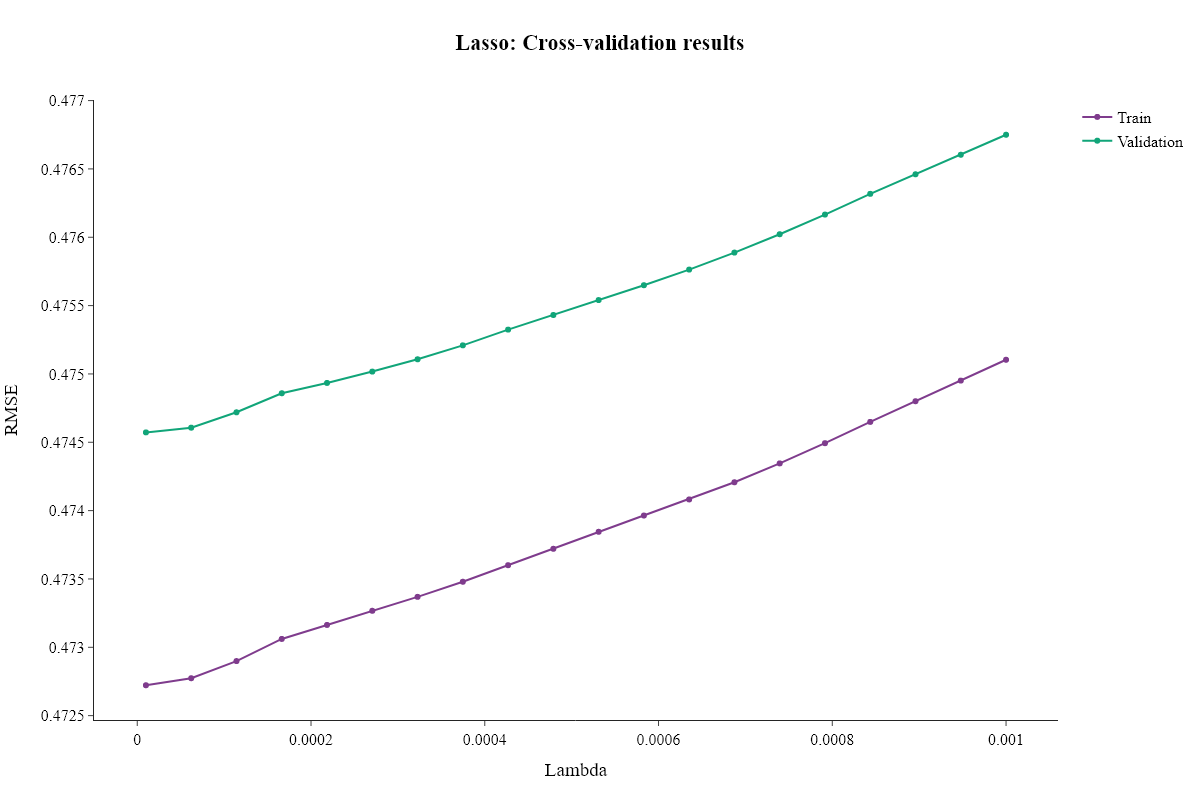

In [12]:
colors = px.colors.qualitative.Bold
fig = go.Figure()
fig.add_trace(go.Scatter(x=lasso_reults['lambda'], y=lasso_reults['train_rmse'], mode='lines+markers', name='Train', line=dict(color=colors[0], width=2)))
fig.add_trace(go.Scatter(x=lasso_reults['lambda'], y=lasso_reults['validation_rmse'], mode='lines+markers', name='Validation', line=dict(color=colors[1], width=2)))
fig.update_layout(template="simple_white", width=1200, height=800, title="<b>Lasso: Cross-validation results</b>", title_x=0.5, xaxis_title="Lambda", yaxis_title="RMSE", font=dict(family="Times New Roman", size=16, color="Black"))
fig.show("png")

**Notes:**
- The higher the worse the model fits the data which results in lower training but also validation scores.

**Conclusions:**
- It looks like applying Lasso regularization has not improved the model at all and we should stick to the model without regularization.

### Ridge

In [13]:
lambdas = np.linspace(1e-3, 10, 20)
ridge_results = pd.DataFrame({'lambda': lambdas, 'train_rmse': np.nan, 'validation_rmse': np.nan})
for lambda_ in lambdas:
    model = Ridge(alpha=lambda_, random_state=SEED)
    train_scores, validation_scores = perform_cv(train_data[best_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
    print("Lambda: {:.6f}; Train {}: {:.4f}; Validation {}: {:.4f}".format(lambda_, compare_metric_name, np.mean(train_scores), compare_metric_name, np.mean(validation_scores)))
    ridge_results.loc[ridge_results['lambda'] == lambda_, 'train_rmse'] = np.mean(train_scores)
    ridge_results.loc[ridge_results['lambda'] == lambda_, 'validation_rmse'] = np.mean(validation_scores)

Lambda: 0.001000; Train RMSE: 0.4727; Validation RMSE: 0.4746
Lambda: 0.527263; Train RMSE: 0.4727; Validation RMSE: 0.4746
Lambda: 1.053526; Train RMSE: 0.4727; Validation RMSE: 0.4746
Lambda: 1.579789; Train RMSE: 0.4727; Validation RMSE: 0.4746
Lambda: 2.106053; Train RMSE: 0.4727; Validation RMSE: 0.4746
Lambda: 2.632316; Train RMSE: 0.4727; Validation RMSE: 0.4746
Lambda: 3.158579; Train RMSE: 0.4727; Validation RMSE: 0.4746
Lambda: 3.684842; Train RMSE: 0.4728; Validation RMSE: 0.4746
Lambda: 4.211105; Train RMSE: 0.4728; Validation RMSE: 0.4746
Lambda: 4.737368; Train RMSE: 0.4728; Validation RMSE: 0.4746
Lambda: 5.263632; Train RMSE: 0.4728; Validation RMSE: 0.4746
Lambda: 5.789895; Train RMSE: 0.4728; Validation RMSE: 0.4746
Lambda: 6.316158; Train RMSE: 0.4728; Validation RMSE: 0.4746
Lambda: 6.842421; Train RMSE: 0.4728; Validation RMSE: 0.4746
Lambda: 7.368684; Train RMSE: 0.4728; Validation RMSE: 0.4746
Lambda: 7.894947; Train RMSE: 0.4728; Validation RMSE: 0.4746
Lambda: 

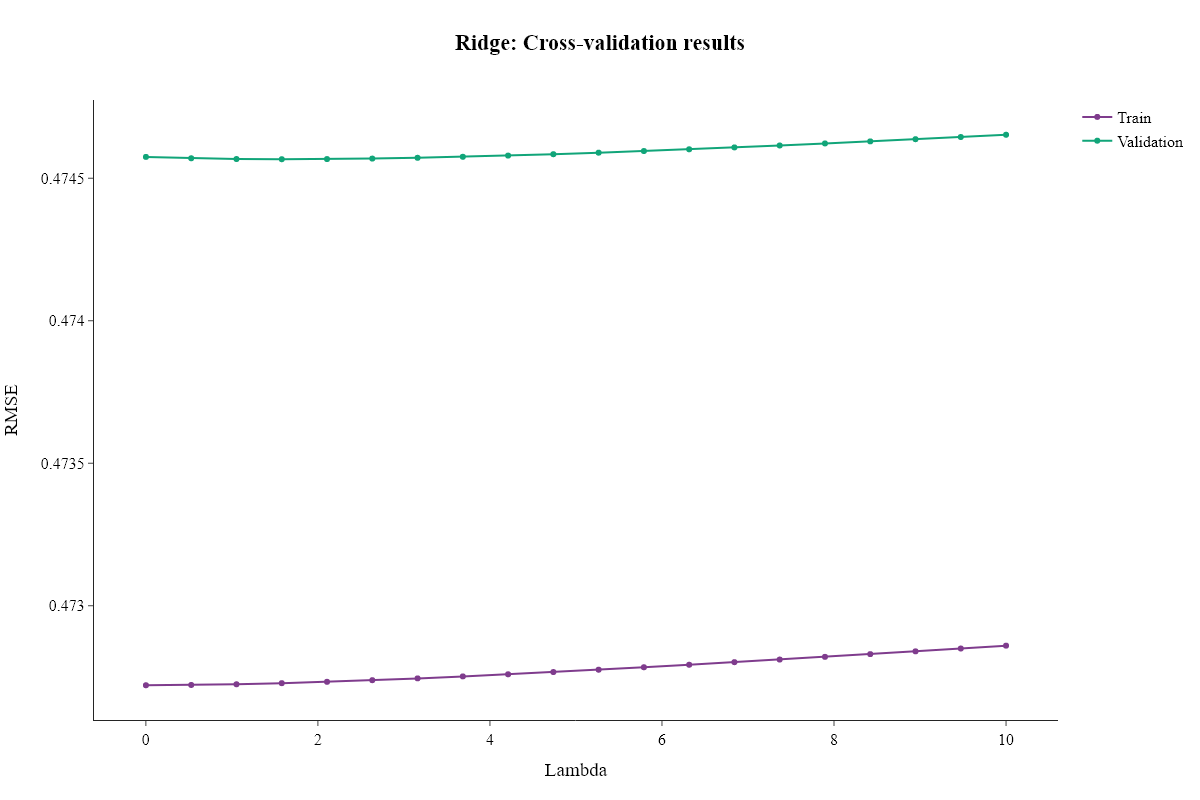

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=ridge_results['lambda'], y=ridge_results['train_rmse'], mode='lines+markers', name='Train', line=dict(color=colors[0], width=2)))
fig.add_trace(go.Scatter(x=ridge_results['lambda'], y=ridge_results['validation_rmse'], mode='lines+markers', name='Validation', line=dict(color=colors[1], width=2)))
fig.update_layout(template="simple_white", width=1200, height=800, title="<b>Ridge: Cross-validation results</b>", title_x=0.5, xaxis_title="Lambda", yaxis_title="RMSE", font=dict(family="Times New Roman", size=16, color="Black"))
fig.show("png")

**Notes:**
- The higher the worse the model fits the data which results in lower training but also validation scores.

**Conclusions:**
- It looks like applying Ridge regularization has not improved the model at all and we should stick to the model without regularization.

# Evaluate model

In [15]:
#Base model
model = LinearRegression(fit_intercept=True)
base_train_scores, base_validation_scores = perform_cv(train_data[independent_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
train_score, base_test_score, y_test_pred = evaluation(train_data[independent_features], train_data[target_feature], test_data[independent_features], test_data[target_feature], model, metric=root_mean_squared_error)

#Tuned model
model = LinearRegression(fit_intercept=True)
tuned_train_scores, tuned_validation_scores = perform_cv(train_data[best_features], train_data[target_feature], model, cv=KFold(n_splits=5, shuffle=True, random_state=SEED), metric=root_mean_squared_error)
tuned_train_score, tuned_test_score, tuned_y_test_pred = evaluation(train_data[best_features], train_data[target_feature], test_data[best_features], test_data[target_feature], model, metric=root_mean_squared_error)

results = pd.DataFrame({'model': ['Base', 'Tuned'], f'Train {compare_metric_name}': [np.mean(base_train_scores), np.mean(tuned_train_scores)], f'Validation {compare_metric_name}': [np.mean(base_validation_scores), np.mean(tuned_validation_scores)], f'Test {compare_metric_name}': [base_test_score, tuned_test_score]})
results.style.background_gradient(cmap='Reds', axis=0)

,model,Train RMSE,Validation RMSE,Test RMSE
0,Base,0.472431,0.474964,0.481450
1,Tuned,0.472721,0.474575,0.481354


## Save model

In [16]:
test_indices = test_data.index
model_LR = {
    "name": "Linear Regression",
    "train_results": tuned_train_score,
    "test_results": tuned_test_score,
    "predictions": tuned_y_test_pred,
    "indices": test_indices
}
with open('Models/model_LR.pkl', 'wb') as f:
    pickle.dump(model_LR, f)